In [285]:
# imports

from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import numpy as np
import numpy.linalg as la
from cvxopt import matrix, solvers
import matplotlib
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.svm import SVC as SVC_sklearn
import matplotlib.pyplot as plt

In [286]:
# a function to prep a given Pandas dataset

# This function performs the following:
# - drops NaN/empty values
# - maps classifiers values -1 or +1 (e.g ["No", "Yes"] -> [-1, 1])
# - separates feature columns from the classifier column
# - splits the data into training and testing sets
# returns: X_train, X_test, y_train, y_test

def prep_data(data, classifier_column_name, classifier_vals=None, train_size=0.75):
    
    # map each binary classifier value to either 1 or -1
    if classifier_vals is not None:
        if len(classifier_vals) != 2:
            raise ValueError("classifier_vals argument must be length 2 (binary classifier)")
        else:
            data[classifier_column_name] = \
                data[classifier_column_name].apply(lambda b: -1 if b == classifier_vals[0] else 1)

    # Drop NaN rows
    data.dropna(axis=0, inplace=True)

    # separate the features from the classifications
    colnames = data.columns.tolist()
    feature_column_names = list(filter(lambda colname: colname != classifier_column_name, colnames))

    X = data[feature_column_names]
    y = data[classifier_column_name]

    # split the data into training and testing data
    datasets = train_test_split(X, y, train_size=train_size)

    # map all the training data into numpy arrays
    X_train, X_test, y_train, y_test = list(map(lambda s: s.to_numpy(), datasets))

    # return the training and testing data
    return X_train, X_test, y_train, y_test


In [287]:
# A class that exposes common kernel functions

def annotate(name, params=None):
    def decorator(f):
        f.name = name
        f.params = params
        return f
    return decorator


class Kernel(object):
    """
    Definitions of some common kernel functions.
    Call each of these functions with their respective kernel parameters to obtain a function object that acts on two training data points x, y.
    """
    @staticmethod
    def linear():
        @annotate(name='Linear')
        def f(x, y):
            return np.inner(x, y)
        return f

    @staticmethod
    def gaussian(sigma):
        @annotate(name='Gaussian', params=dict(sigma=sigma))
        def f(x, y):
            exponent = -np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2))
            return np.exp(exponent)
        return f

    @staticmethod
    def polynomial(dimension, offset):
        @annotate(name='Polynomial', params=dict(dimension=dimension, offset=offset))
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel.polynomial(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel.polynomial(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        @annotate(name='Hyperbolic Tangent', params=dict(kappa=kappa, c=c))
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

    @staticmethod
    def rbf(gamma):
        @annotate(name='rbf', params=dict(gamma=gamma))
        def f(x, y):
            return (np.exp(-gamma*(np.linalg.norm(x - y))**2))
        return f

In [288]:
# The Model group's implementation of the Support Vector Classifier
# Computes the SVM via the dual optimization problem, a quadratic program
class SVC(object):
    """
    Our definition of an SVC Classifier Model.
    """
    # constructor
    def __init__(self, kernel=Kernel.linear(), C=1.0):
        # kernel is a function : (xi, xj) -> number
        self.kernel = kernel
        self.C = C

    # helper function to build kernel matrix
    def _build_k(self, X):
        """
        build_k generates a kernel to use inside of an SVM calculation
        X: Training data for our calculations
        kernel_type: Specifies the type of kernel to use: linear_kernel, polynomial_kernel, rbf_kernel
        poly_power: An optional parameter to define to what degree the polynomial should be calculated
        gamma: An optional parameter that defines how far the influence of a single training example reaches
        :return:
        """
        kernel = self.kernel
        N = X.shape[0]
        K = np.zeros((N, N))
        for i in range(N):
            x_i = X[i]
            for j in range(N):
                x_j = X[j]

                K[i][j] = kernel(x_i, x_j)

        return K

    # solve the dual SVM problem with given training data
    # find alphas, w, and b for use in predictions
    def fit(self, X, y):
        """
        SVM will calculate the weight and bias using the SVM quadratic method (soft margin)
        X: Training data used for calculations 
        y: results of training data
        kernel_type: Specifies the type of kernel to use: linear_kernel, polynomial_kernel, rbf_kernel
        C: Trades off misclassification of training examples against simplicity of the decision surface
        :return: weight, bias, and alphas matrix

        Help used: https://stats.stackexchange.com/questions/23391/how-does-a-support-vector-machine-svm-work/353605#353605
        """
        # map member variables / methods to shorter aliases
        C = self.C
        kernel = self.kernel
        build_k = self._build_k

        # Grabs shape of our training data
        m, _ = X.shape

        # Make sure y values are floats and within -1 == y == 1
        y = y.reshape(-1,1) * 1.

        # Calculate our kernel
        K = build_k(X)

        # Compute 
        H = np.matmul(y,y.T) * K * 1.

        #Converting into cvxopt format - as previously
        P = cvxopt_matrix(H)
        q = cvxopt_matrix(-np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = cvxopt_matrix(y.reshape(1, -1))
        b = cvxopt_matrix(np.zeros(1))

        # disable outputs from solver
        solvers.options['qp'] = dict(msg_lev='QP_MSG_OFF')
        solvers.options['show_progress'] = False

        # Run solver
        sol = cvxopt_solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])

        # Calculating w, b
        w = ((y * alphas).T @ X).reshape(-1,1).flatten()
        S = (alphas > 1e-4).flatten()

        sv = X[S]
        sv_y = y[S]
        alphas = alphas[S]
        b = sv_y - np.sum(build_k(sv) * alphas * sv_y, axis=0)
        b = [np.sum(b) / b.size]

        # set the member variables for building the predict method
        self.alphas = alphas.flatten()
        self.w = w
        self.b = b[0]

        ### build the prediction function ###

        # classifies a single sample as +1 or -1
        def classify_sample(x):
            return (1 if kernel(w, x) + b >= 0 else -1)

        # classifies multiple samples as +1 or -1 -> outputs array
        def classify_samples(X_test):
            return np.apply_along_axis(classify_sample, 1, X_test)

        def classify(X):
            if X.shape == w.shape:
                return classify_sample(X)
            elif len(X.shape) > 1 and X[0].shape == w.shape:
                return classify_samples(X)
            else:
                raise Exception("Invalid test data shape. Either input an array (single sample) or a 2d array (multiple samples).")

        self._predict = classify

    # predict the binary classifications {-1,1} of test sample arrays in X
    # outputs a vector (or value) of classifications in {-1,1}
    # requires that fit() was called previously
    def predict(self, X):
        # if data not fitted -> predict function not valid
        if self._predict is None:
            raise Exception("SVC Model must be fitted before prediction. Utilize fit() method with training data.")

        # otherwise, return the prediction results
        # can be given a single sample (shape equal to w)
        # or multiple samples (a 2d array with elements that have shape equal to w)
        return self._predict(X)

In [289]:
# A function to evaluate classifier performance over test data

def evaluate_classifier(classifier, X_test, y_test):
    numtests = X_test.shape[0]
    results = classifier(X_test) == y_test.flatten()
    numcorrect = np.count_nonzero(results)
    successrate = numcorrect / numtests
    return successrate

### Demonstration

In this section, we demonstrate our SVC model on a sample data set using the linear and polynomial kernels. This section serves to demonstrate how to use our SVC class. We strove to expose the same methods (i.e. fit() and predict()) as are provided by the Scikit Learn implementation of SVC.

In [290]:
# Read a data set into Pandas DataFrame
data = pd.read_csv('./data/test-data/test_data.csv')

# Prepare our data for SVC
X_train, X_test, y_train, y_test = prep_data(
    data=data, # the Pandas DataFrame
    classifier_column_name="success", # classification column name
    classifier_vals=[0.0, 1.0], # classification values -> mapped to {-1, 1}
    train_size=0.75 # the proportion of data to allocate for training
)

In [291]:
# A procedure that plots a 2D SVC classification
# Plots the hyperplane and sample point classifications
def plot_SVC_2d(X, y, is_linear=False, w=None, b=None, title=None):
    if len(X.shape) < 2 or X[0].shape != (2,):
        raise Exception("X has invalid shape. X must be an array of 2d arrays.")

    plt.figure(figsize=(8, 8))

    # Plot the data points
    colors = ["steelblue", "orange"]
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black", zorder=2,)

    # Plot the hyperplane if linear kernel
    if is_linear and w is not None and b is not None:
        x_coords = X[:, 0]
        x_min = np.min(x_coords)
        x_max = np.max(x_coords)

        x_points = np.linspace(x_min, x_max)    # generating x-points across x range
        y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
        plt.plot(x_points, y_points, zorder=1, c='r')

    if title: plt.title(title)

    plt.show()

Kernel: Linear
C = 1.0
Our success rate: 0.88
SKLearn success rate: 0.8533333333333334


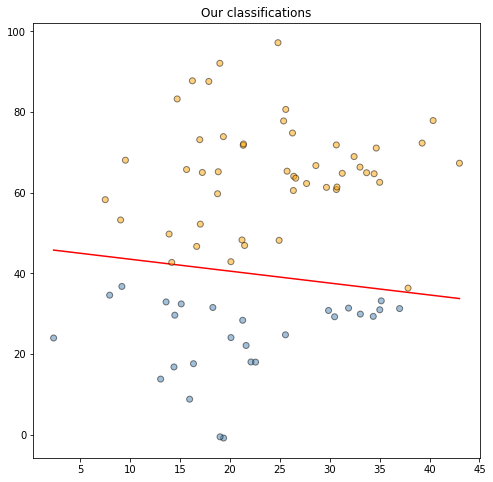

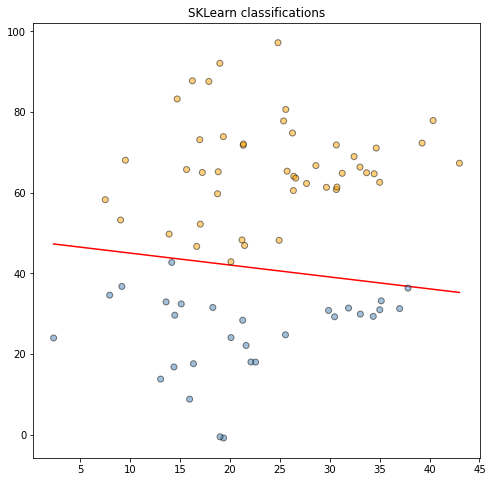

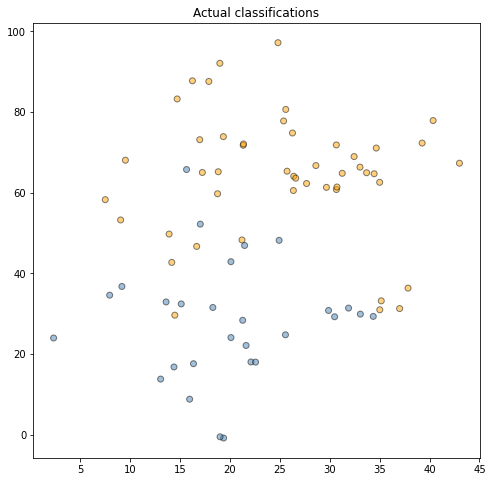

In [292]:
# Demonstration 1: Linear Kernel
# Define test parameters for the SVC
# use a linear kernel function and C=1.0
kernel = Kernel.linear()
C = 1.0

# Our SVC model -> fit and evaluate
our_svc = SVC(kernel=kernel, C=C)
our_svc.fit(X_train, y_train)
our_result = evaluate_classifier(our_svc.predict, X_test, y_test)

# SciKit Learn SVC model -> fit and evaluate
sklearn_svc = SVC_sklearn(kernel='linear', C=C)
sklearn_svc.fit(X_train, y_train)
sklearn_result = evaluate_classifier(sklearn_svc.predict, X_test, y_test)

# Print results
print(f"Kernel: {kernel.name}")
if kernel.params: print(f"Kernel parameters: {kernel.params}")
print(f"C = {C}")
print(f"Our success rate: {our_result}")
print(f"SKLearn success rate: {sklearn_result}")

# Plot our classifications
w = our_svc.w
b = our_svc.b
plot_SVC_2d(X_test, our_svc.predict(X_test), is_linear=True, w=our_svc.w, b=our_svc.b, title="Our classifications")

# Plot SKLearn classifications
w = sklearn_svc.coef_[0]
b = sklearn_svc.intercept_[0]
plot_SVC_2d(X_test, sklearn_svc.predict(X_test), is_linear=True, w=sklearn_svc.coef_[0], b=sklearn_svc.intercept_[0], title="SKLearn classifications")

# Plot actual classifications
plot_SVC_2d(X_test, y_test, title="Actual classifications")

Kernel: Polynomial
Kernel parameters: {'dimension': 3, 'offset': 0}
C = 1.0
Our success rate: 0.7333333333333333
SKLearn success rate: 0.8933333333333333


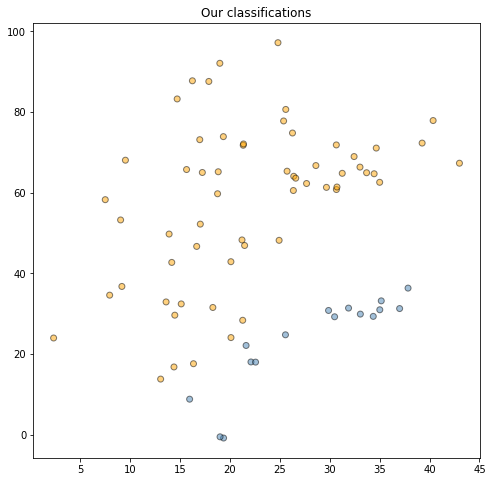

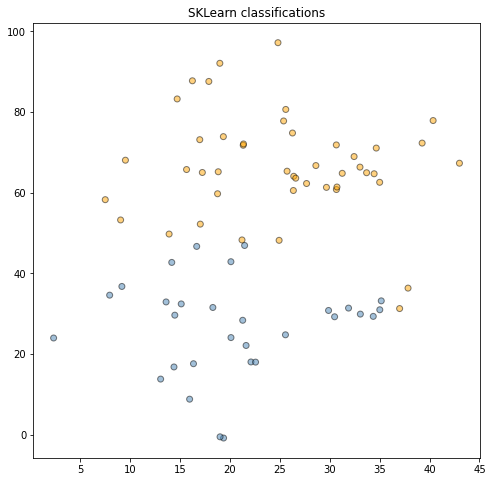

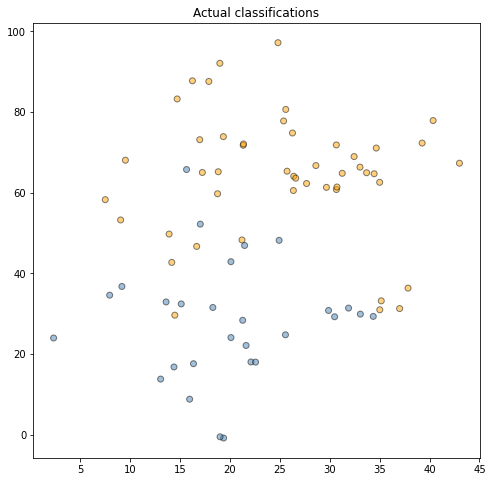

In [293]:
# Demonstration 2: Polynomial Kernel
# Define test parameters for the SVC
# use a polynomial kernel function (with dimension=3, offset=0) and C=1.0

# Define test parameters for the SVC
# use a linear kernel function and C=1.0
kernel = Kernel.polynomial(dimension=3, offset=0)
C = 1.0

# Our SVC model -> fit and evaluate
our_svc = SVC(kernel=kernel, C=C)
our_svc.fit(X_train, y_train)
our_result = evaluate_classifier(our_svc.predict, X_test, y_test)

# SciKit Learn SVC model -> fit and evaluate
sklearn_svc = SVC_sklearn(kernel='poly', degree=3, coef0=0, C=C)
sklearn_svc.fit(X_train, y_train)
sklearn_result = evaluate_classifier(sklearn_svc.predict, X_test, y_test)

# Print results
print(f"Kernel: {kernel.name}")
if kernel.params: print(f"Kernel parameters: {kernel.params}")
print(f"C = {C}")
print(f"Our success rate: {our_result}")
print(f"SKLearn success rate: {sklearn_result}")

# Plot our classifications
plot_SVC_2d(X_test, our_svc.predict(X_test), title="Our classifications")

# Plot SKLearn classifications
plot_SVC_2d(X_test, sklearn_svc.predict(X_test), title="SKLearn classifications")

# Plot actual classifications
plot_SVC_2d(X_test, y_test, title="Actual classifications")